In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
from os.path import join
import torch
import torch as th
import torch.nn.functional as F
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle as pkl
from tqdm.auto import trange
from contextlib import redirect_stdout
import sys
sys.path.append("/n/home12/binxuwang/Github/DiffusionObjectRelation/PixArt-alpha")
from diffusion import IDDPM
from diffusion.data.builder import build_dataset, build_dataloader, set_data_root
from diffusion.model.builder import build_model
from diffusion.utils.misc import set_random_seed, read_config, init_random_seed, DebugUnderflowOverflow
sys.path.append("/n/home12/binxuwang/Github/DiffusionObjectRelation")
from utils.cv2_eval_utils import evaluate_pipeline_on_prompts, print_evaluation_summary
from utils.relation_shape_dataset_lib import ShapesDataset
from utils.variance_partition_with_effects import variance_partition_with_effects#, variance_partition
from utils.pixart_sampling_utils import pipeline_inference_custom, \
    PixArtAlphaPipeline_custom, PixArtAlphaPipeline_custom_CLIP
from utils.pixart_utils import state_dict_convert
from utils.text_encoder_control_lib import RandomEmbeddingEncoder_wPosEmb
from utils.image_utils import pil_images_to_grid
from utils.attention_map_store_utils import replace_attn_processor, AttnProcessor2_0_Store, PixArtAttentionVisualizer_Store
from utils.cv2_eval_utils import find_classify_object_masks
from diffusers import AutoencoderKL, Transformer2DModel, PixArtAlphaPipeline, DPMSolverMultistepScheduler
from transformers import T5Tokenizer, T5EncoderModel

In [4]:
from itertools import product
def generate_all_prompt_collection(spatial_phrases, 
                               prompt_template="{color1} {shape1} is {rel_text} {color2} {shape2}",):
    color_list = ['red', 'blue']
    shape_list = ['square', 'triangle', 'circle']
    prompt_collection = []
    scene_info_collection = []
    for color1, color2 in product(color_list, color_list):
        if color1 == color2:      # skip same‐color pairs
            continue
        for shape1, shape2 in product(shape_list, shape_list):
            if shape1 == shape2:
                continue
            for spatial_relationship, rel_text_collection in spatial_phrases.items():
                if spatial_relationship in ["in_front", "behind"]:
                    continue
                for rel_text in rel_text_collection:
                    prompt = prompt_template.format(color1=color1, shape1=shape1, rel_text=rel_text, color2=color2, shape2=shape2)
                    scene_info = {
                        "color1": color1,
                        "shape1": shape1,
                        "color2": color2,
                        "shape2": shape2,
                        "spatial_relationship": spatial_relationship
                    }
                    prompt_collection.append(prompt)
                    scene_info_collection.append(scene_info)
    return prompt_collection, scene_info_collection

In [5]:
from experimental_scripts.generalization_profile_eval_cli import evaluate_pipeline_on_prompts_with_cached_embeddings, precompute_embeddings
def find_shape_index(tokens, shape):
    """Find the token index for a shape in the tokenized text."""
    shape_mask_idx = None
    
    # Look for exact token matches first
    for i, token in enumerate(tokens):
        token_clean = token.strip().lower()
        shape_clean = shape.strip().lower()
        
        # Check for exact matches first
        if token_clean == shape_clean or token_clean == f"▁{shape_clean}":
            shape_mask_idx = i
            break
    
    # If exact match not found, look for partial matches
    if shape_mask_idx is None:
        for i, token in enumerate(tokens):
            token_clean = token.strip().lower()
            shape_clean = shape.strip().lower()
            
            if shape_clean in token_clean:
                shape_mask_idx = i
                break
    
    return shape_mask_idx

def find_word_index(tokens, word):
    """Find the token index for a shape in the tokenized text."""
    shape_mask_idx = None
    
    # Look for exact token matches first
    for i, token in enumerate(tokens):
        token_clean = token.strip().lower()
        shape_clean = word.strip().lower()
        
        # Check for exact matches first
        if token_clean == shape_clean or token_clean == f"▁{shape_clean}":
            shape_mask_idx = i
            break
    
    # If exact match not found, look for partial matches
    if shape_mask_idx is None:
        for i, token in enumerate(tokens):
            token_clean = token.strip().lower()
            shape_clean = word.strip().lower()
            
            if shape_clean in token_clean:
                shape_mask_idx = i
                break
    
    return shape_mask_idx

In [6]:
from transformers import CLIPTextModelWithProjection, CLIPTokenizer
# Load SDXL's text encoder and tokenizer (text_encoder_2 and tokenizer_2)
text_encoder = CLIPTextModelWithProjection.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", subfolder="text_encoder_2", 
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",)
tokenizer = CLIPTokenizer.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", subfolder="tokenizer_2", 
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",)

In [ ]:
run_name = "objrel_CLIPemb_DiT_mini_pilot"
savedir = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/{run_name}"

config = read_config(join(savedir, 'config.py'))

weight_dtype = torch.float32
if config.mixed_precision == "fp16": # accelerator.
    weight_dtype = torch.float16
elif config.mixed_precision == "bf16": # accelerator.
    weight_dtype = torch.bfloat16
    
image_size = config.image_size  # @param [256, 512, 1024]
latent_size = int(image_size) // 8
pred_sigma = getattr(config, 'pred_sigma', True)
learn_sigma = getattr(config, 'learn_sigma', True) and pred_sigma
model_kwargs={"window_block_indexes": config.window_block_indexes, "window_size": config.window_size,
                "use_rel_pos": config.use_rel_pos, "lewei_scale": config.lewei_scale, 'config':config,
                'model_max_length': config.model_max_length, "caption_channels": config.caption_channels}
# train_diffusion = IDDPM(str(config.train_sampling_steps), learn_sigma=learn_sigma, pred_sigma=pred_sigma, snr=config.snr_loss)
model = build_model(config.model,
                config.grad_checkpointing,
                config.get('fp32_attention', False),
                input_size=latent_size,
                learn_sigma=learn_sigma,
                pred_sigma=pred_sigma,
                **model_kwargs).train()

transformer = Transformer2DModel(
        sample_size=image_size // 8,
        num_layers=len(model.blocks),
        attention_head_dim=model.blocks[0].hidden_size // model.num_heads,
        in_channels=model.in_channels,
        out_channels=model.out_channels,
        patch_size=model.patch_size,
        attention_bias=True,
        num_attention_heads=model.num_heads,
        cross_attention_dim=model.blocks[0].hidden_size,
        activation_fn="gelu-approximate",
        num_embeds_ada_norm=1000,
        norm_type="ada_norm_single",
        norm_elementwise_affine=False,
        norm_eps=1e-6,
        caption_channels=config.caption_channels,
)
# state_dict = state_dict_convert(all_state_dict.pop("state_dict"))
transformer.load_state_dict(state_dict_convert(model.state_dict()))
pipeline = PixArtAlphaPipeline_custom_CLIP.from_pretrained(
    "PixArt-alpha/PixArt-XL-2-512x512",
    transformer=transformer,
    tokenizer=None,
    text_encoder=None,
    torch_dtype=weight_dtype,
)

pipeline.tokenizer = tokenizer
pipeline.to(device="cuda", dtype=weight_dtype);
# pipeline.to(device="cuda", dtype=torch.bfloat16);
pipeline.text_encoder = text_encoder.to(device="cuda", )

2026-01-26 18:41:29,784 - PixArt - WARNING - lewei scale: (1.0,), base size: 8


Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

Expected types for transformer: (<class 'diffusers.models.transformers.pixart_transformer_2d.PixArtTransformer2DModel'>,), got <class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>.


In [8]:
ckptdir = join(savedir, "checkpoints")
ckpt = torch.load(join(ckptdir, "epoch_4000_step_160000.pth"))
pipeline.transformer.load_state_dict(state_dict_convert(ckpt['state_dict_ema']))

/tmp/ipykernel_3124008/1495998778.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(join(ckptdir, "epoch_4000_step_160000.pth"))


<All keys matched successfully>

### Make all embeddings

In [9]:
dataset_tmp = ShapesDataset(num_images=10000)
prompt_collection_all, scene_info_collection_all = generate_all_prompt_collection(dataset_tmp.spatial_phrases,
                                prompt_template="{color1} {shape1} is {rel_text} {color2} {shape2}",)
embedding_allrel_allobj = precompute_embeddings({"base":(prompt_collection_all, scene_info_collection_all)}, 
                                        pipeline.tokenizer, pipeline.text_encoder, 
                                        max_sequence_length=20, device="cuda")
prompt_scene_info_all_df = pd.DataFrame(scene_info_collection_all)
prompt_scene_info_all_df["prompt"] = prompt_collection_all
prompt_scene_info_all_df
wordvec_obj1_col = []
wordvec_obj2_col = []
for row in prompt_scene_info_all_df.itertuples():
    tokenized = pipeline.tokenizer(row.prompt, max_length=20, padding="max_length", truncation=True, return_tensors="pt")
    token_ids = tokenized['input_ids'][0]
    tokens = [pipeline.tokenizer.decode([token_id]) for token_id in token_ids]
    
    shape1_mask_idx = find_shape_index(tokens, row.shape1)
    shape2_mask_idx = find_shape_index(tokens, row.shape2)
    cap_embeds = embedding_allrel_allobj[f"base::{row.prompt}"]['caption_embeds']
    if shape1_mask_idx is None or shape2_mask_idx is None:
        print(f"Prompt: {row.prompt}")
        print(f"Shape1 ({row.shape1}) at index: {shape1_mask_idx}")
        print(f"Shape2 ({row.shape2}) at index: {shape2_mask_idx}")
        print("---")
        raise ValueError("Shape index not found")
    wordvec_obj1_col.append(cap_embeds[0, shape1_mask_idx, :])
    wordvec_obj2_col.append(cap_embeds[0, shape2_mask_idx, :])
wordvec_obj1_mat = torch.stack(wordvec_obj1_col, dim=0)
wordvec_obj2_mat = torch.stack(wordvec_obj2_col, dim=0)

Pre-computing text embeddings for all prompts...
Computing unconditional embedding...


Computing embeddings:   0%|          | 0/265 [00:00<?, ?it/s]

Cached embeddings for 265 unique prompts (including uncond)


In [12]:
with torch.no_grad():
    wordvec_obj1_mat_proj = pipeline.transformer.caption_projection(wordvec_obj1_mat.half().cuda())
    wordvec_obj2_mat_proj = pipeline.transformer.caption_projection(wordvec_obj2_mat.half().cuda())

In [10]:
prompt_scene_info_all_df["color1shape1"] = prompt_scene_info_all_df["color1"] + "_" + prompt_scene_info_all_df["shape1"]
prompt_scene_info_all_df["color2shape2"] = prompt_scene_info_all_df["color2"] + "_" + prompt_scene_info_all_df["shape2"]

var_part_df, intercept, effect_vecs, levels_map, R2_total = variance_partition_with_effects(wordvec_obj2_mat.float().cpu().numpy(),
            {"spatial_relationship": prompt_scene_info_all_df["spatial_relationship"],
             "color1": prompt_scene_info_all_df["color1"],
             "shape1": prompt_scene_info_all_df["shape1"],
             "color2": prompt_scene_info_all_df["color2"],
             "shape2": prompt_scene_info_all_df["shape2"],
             "color1shape1": prompt_scene_info_all_df["color1shape1"],
             "color2shape2": prompt_scene_info_all_df["color2shape2"],
             },
            metric="euclidean",
            n_perm=100)
var_part_df

Total R2 (all features): 0.891531
Total R² (all features): 0.8915


,feature,levels,df_effect,df_resid,SS_total,SSR_marginal,R2_marginal,SSR_partial,R2_partial,eta2_partial,p_partial_perm
0,color2shape2,6,5,247,180323.08823,151023.100617,0.837514,1.232946e+04,6.837425e-02,3.866384e-01,0.009901
1,spatial_relationship,8,7,247,180323.08823,5124.431892,0.028418,5.124432e+03,2.841806e-02,2.076028e-01,0.009901
2,color1shape1,6,5,247,180323.08823,59573.230312,0.330369,7.136396e+02,3.957561e-03,3.520141e-02,0.009901
3,color2,2,1,247,180323.08823,17497.454196,0.097034,1.433485e-11,7.949539e-17,7.328882e-16,1.000000
4,color1,2,1,247,180323.08823,17497.454196,0.097034,1.433485e-11,7.949539e-17,7.328882e-16,1.000000
5,shape1,3,2,247,180323.08823,37455.281996,0.207712,-8.405627e-11,-4.661426e-16,-4.297487e-15,1.000000
6,shape2,3,2,247,180323.08823,117289.336289,0.650440,-1.231387e-10,-6.828782e-16,-6.295628e-15,1.000000


In [107]:
prompt_scene_info_all_df["color1shape1"] = prompt_scene_info_all_df["color1"] + "_" + prompt_scene_info_all_df["shape1"]
prompt_scene_info_all_df["color2shape2"] = prompt_scene_info_all_df["color2"] + "_" + prompt_scene_info_all_df["shape2"]
print("Shape2, CLIP Embedding")
var_part_df, intercept, effect_vecs, levels_map, R2_total = variance_partition_with_effects(wordvec_obj2_mat.float().cpu().numpy(),
            {"spatial_relationship": prompt_scene_info_all_df["spatial_relationship"],
            #  "color1": prompt_scene_info_all_df["color1"],
             "shape1": prompt_scene_info_all_df["shape1"],
            #  "color2": prompt_scene_info_all_df["color2"],
            #  "shape2": prompt_scene_info_all_df["shape2"],
            #  "color1shape1": prompt_scene_info_all_df["color1shape1"],
             "color2shape2": prompt_scene_info_all_df["color2shape2"],
             },
            metric="euclidean",
            n_perm=100)
var_part_df

Shape2, CLIP Embedding
Total R2 (all features): 0.887574
Total R² (all features): 0.8876


,feature,levels,df_effect,df_resid,SS_total,SSR_marginal,R2_marginal,SSR_partial,R2_partial,eta2_partial,p_partial_perm
0,color2shape2,6,5,249,180323.08823,151023.100617,0.837514,117470.332952,0.651444,0.852820,0.009901
1,spatial_relationship,8,7,249,180323.08823,5124.431892,0.028418,5124.431892,0.028418,0.201769,0.009901
2,shape1,3,2,249,180323.08823,37455.281996,0.207712,3902.514331,0.021642,0.161424,0.009901


In [109]:
prompt_scene_info_all_df["color1shape1"] = prompt_scene_info_all_df["color1"] + "_" + prompt_scene_info_all_df["shape1"]
prompt_scene_info_all_df["color2shape2"] = prompt_scene_info_all_df["color2"] + "_" + prompt_scene_info_all_df["shape2"]
print("Shape2, CLIP Embedding")
var_part_df, intercept, effect_vecs, levels_map, R2_total = variance_partition_with_effects(wordvec_obj2_mat.float().cpu().numpy(),
            {"spatial_relationship": prompt_scene_info_all_df["spatial_relationship"],
            #  "color1": prompt_scene_info_all_df["color1"],image.png
            #  "shape1": prompt_scene_info_all_df["shape1"],
            #  "color2": prompt_scene_info_all_df["color2"],
            #  "shape2": prompt_scene_info_all_df["shape2"],
            #  "color1shape1": prompt_scene_info_all_df["color1shape1"],
             "color2shape2": prompt_scene_info_all_df["color2shape2"],
             },
            metric="euclidean",
            n_perm=100)
var_part_df

Shape2, CLIP Embedding
Total R2 (all features): 0.865932
Total R² (all features): 0.8659


,feature,levels,df_effect,df_resid,SS_total,SSR_marginal,R2_marginal,SSR_partial,R2_partial,eta2_partial,p_partial_perm
0,color2shape2,6,5,251,180323.08823,151023.100617,0.837514,151023.100617,0.837514,0.862011,0.009901
1,spatial_relationship,8,7,251,180323.08823,5124.431892,0.028418,5124.431892,0.028418,0.174895,0.009901


In [108]:
prompt_scene_info_all_df["color1shape1"] = prompt_scene_info_all_df["color1"] + "_" + prompt_scene_info_all_df["shape1"]
prompt_scene_info_all_df["color2shape2"] = prompt_scene_info_all_df["color2"] + "_" + prompt_scene_info_all_df["shape2"]
print("Shape2, CLIP Embedding, PixArt Caption Projection")
var_part_df, intercept, effect_vecs, levels_map, R2_total = variance_partition_with_effects(wordvec_obj2_mat_proj.float().cpu().numpy(),
            {"spatial_relationship": prompt_scene_info_all_df["spatial_relationship"],
            #  "color1": prompt_scene_info_all_df["color1"],
             "shape1": prompt_scene_info_all_df["shape1"],
            #  "color2": prompt_scene_info_all_df["color2"],
            #  "shape2": prompt_scene_info_all_df["shape2"],
            #  "color1shape1": prompt_scene_info_all_df["color1shape1"],
             "color2shape2": prompt_scene_info_all_df["color2shape2"],
             },
            metric="euclidean",
            n_perm=100)
var_part_df

Shape2, CLIP Embedding, PixArt Caption Projection
Total R2 (all features): 0.555614
Total R² (all features): 0.5556


,feature,levels,df_effect,df_resid,SS_total,SSR_marginal,R2_marginal,SSR_partial,R2_partial,eta2_partial,p_partial_perm
0,color2shape2,6,5,249,34851.527819,11675.831563,0.335016,10724.922310,0.307732,0.409154,0.009901
1,spatial_relationship,8,7,249,34851.527819,6006.954735,0.172358,6006.954735,0.172358,0.279465,0.009901
2,shape1,3,2,249,34851.527819,2632.121861,0.075524,1681.212608,0.048239,0.097923,0.009901


In [110]:
prompt_scene_info_all_df["color1shape1"] = prompt_scene_info_all_df["color1"] + "_" + prompt_scene_info_all_df["shape1"]
prompt_scene_info_all_df["color2shape2"] = prompt_scene_info_all_df["color2"] + "_" + prompt_scene_info_all_df["shape2"]
print("Shape1, CLIP Embedding")
var_part_df, intercept, effect_vecs, levels_map, R2_total = variance_partition_with_effects(wordvec_obj1_mat.float().cpu().numpy(),
            {"spatial_relationship": prompt_scene_info_all_df["spatial_relationship"],
             "color1": prompt_scene_info_all_df["color1"], 
             "shape1": prompt_scene_info_all_df["shape1"],
            #  "color2": prompt_scene_info_all_df["color2"],
            #  "shape2": prompt_scene_info_all_df["shape2"],
             "color1shape1": prompt_scene_info_all_df["color1shape1"],
            #  "color2shape2": prompt_scene_info_all_df["color2shape2"],
             },
            metric="euclidean",
            n_perm=100)
var_part_df

Shape1, CLIP Embedding
Total R2 (all features): 1.000000
Total R² (all features): 1.0000


,feature,levels,df_effect,df_resid,SS_total,SSR_marginal,R2_marginal,SSR_partial,R2_partial,eta2_partial,p_partial_perm
0,color1shape1,6,5,251,176481.343236,1.764813e+05,1.000000e+00,1.294874e+04,7.337173e-02,1.0,0.009901
1,color1,2,1,251,176481.343236,3.044077e+04,1.724872e-01,7.387975e-11,4.186264e-16,NaN,0.168317
2,spatial_relationship,8,7,251,176481.343236,-1.711259e-12,-9.696545e-18,9.538257e-12,5.404683e-17,NaN,0.326733
3,shape1,3,2,251,176481.343236,1.330918e+05,7.541411e-01,-3.798743e-11,-2.152490e-16,NaN,0.138614


In [111]:
prompt_scene_info_all_df["color1shape1"] = prompt_scene_info_all_df["color1"] + "_" + prompt_scene_info_all_df["shape1"]
prompt_scene_info_all_df["color2shape2"] = prompt_scene_info_all_df["color2"] + "_" + prompt_scene_info_all_df["shape2"]
print("Shape1, CLIP Embedding, PixArt Caption Projection")
var_part_df, intercept, effect_vecs, levels_map, R2_total = variance_partition_with_effects(wordvec_obj1_mat_proj.float().cpu().numpy(),
            {"spatial_relationship": prompt_scene_info_all_df["spatial_relationship"],
             "color1": prompt_scene_info_all_df["color1"], 
             "shape1": prompt_scene_info_all_df["shape1"],
            #  "color2": prompt_scene_info_all_df["color2"],
            #  "shape2": prompt_scene_info_all_df["shape2"],
             "color1shape1": prompt_scene_info_all_df["color1shape1"],
            #  "color2shape2": prompt_scene_info_all_df["color2shape2"],
             },
            metric="euclidean",
            n_perm=100)
var_part_df

Shape1, CLIP Embedding, PixArt Caption Projection
Total R2 (all features): 1.000000
Total R² (all features): 1.0000


,feature,levels,df_effect,df_resid,SS_total,SSR_marginal,R2_marginal,SSR_partial,R2_partial,eta2_partial,p_partial_perm
0,color1shape1,6,5,251,11464.844555,1.146484e+04,1.000000e+00,3.458994e+03,3.017044e-01,1.000000,0.009901
1,color1,2,1,251,11464.844555,2.995373e+03,2.612659e-01,4.508740e-12,3.932666e-16,6.375069,0.168317
2,spatial_relationship,8,7,251,11464.844555,1.737805e-14,1.515769e-18,3.917994e-12,3.417398e-16,33.631068,0.316832
3,shape1,3,2,251,11464.844555,5.010477e+03,4.370297e-01,-3.328563e-12,-2.903278e-16,NaN,0.178218


In clip model the shape1 has no spatial relation. Shape2 has more spatial relation concentration

In [16]:
levels_map

{'spatial_relationship': array(['above', 'below', 'left', 'lower_left', 'lower_right', 'right',
        'upper_left', 'upper_right'], dtype=object),
 'shape1': array(['circle', 'square', 'triangle'], dtype=object),
 'color2shape2': array(['blue_circle', 'blue_square', 'blue_triangle', 'red_circle',
        'red_square', 'red_triangle'], dtype=object)}

In [14]:
effect_vecs

{'spatial_relationship': array([[-0.06140686,  0.40481986,  0.1125255 , ..., -0.26785468,
         -0.13326853, -0.12824127],
        [ 0.20667062,  0.20034679, -0.41341912, ...,  0.41745441,
          0.09079238,  0.08775282],
        [ 0.26684466,  0.30216212, -0.12697361, ...,  0.21887664,
          0.12123779, -0.17610284],
        ...,
        [ 0.12930003, -0.41981798, -0.32900665, ..., -0.23604604,
          0.07815937,  0.13737932],
        [-0.18446412,  0.16005744,  0.5146376 , ..., -0.18449189,
         -0.00982281, -0.22713624],
        [-0.45695515, -0.20293559,  0.39490294, ..., -0.39806301,
         -0.04369795,  0.22434123]]),
 'shape1': array([[-0.01026233,  0.02810129,  0.02927182, ...,  0.16457165,
         -0.03480981,  0.15889866],
        [ 0.03724919,  0.00139994,  0.05245738, ...,  0.01776042,
          0.00827466, -0.16896869],
        [-0.02698686, -0.02950122, -0.0817292 , ..., -0.18233207,
          0.02653515,  0.01007002]]),
 'color2shape2': array([[-0.049

### Cross attention map 

### Factors relating to spatial cosine embedding

In [113]:
prompt_scene_info_all_df["color1shape1"] = prompt_scene_info_all_df["color1"] + "_" + prompt_scene_info_all_df["shape1"]
prompt_scene_info_all_df["color2shape2"] = prompt_scene_info_all_df["color2"] + "_" + prompt_scene_info_all_df["shape2"]

var_part_df, intercept, effect_vecs, levels_map, R2_total = variance_partition_with_effects(wordvec_obj2_mat_proj.float().cpu().numpy(),
            {"spatial_relationship": prompt_scene_info_all_df["spatial_relationship"],
            #  "color1": prompt_scene_info_all_df["color1"],
             "shape1": prompt_scene_info_all_df["shape1"],
            #  "color2": prompt_scene_info_all_df["color2"],
            #  "shape2": prompt_scene_info_all_df["shape2"],
            #  "color1shape1": prompt_scene_info_all_df["color1shape1"],
             "color2shape2": prompt_scene_info_all_df["color2shape2"],
             },
            metric="euclidean",
            n_perm=100)
var_part_df

Total R2 (all features): 0.555614
Total R² (all features): 0.5556


,feature,levels,df_effect,df_resid,SS_total,SSR_marginal,R2_marginal,SSR_partial,R2_partial,eta2_partial,p_partial_perm
0,color2shape2,6,5,249,34851.527819,11675.831563,0.335016,10724.922310,0.307732,0.409154,0.009901
1,spatial_relationship,8,7,249,34851.527819,6006.954735,0.172358,6006.954735,0.172358,0.279465,0.009901
2,shape1,3,2,249,34851.527819,2632.121861,0.075524,1681.212608,0.048239,0.097923,0.009901


In [20]:
from diffusion.model.nets.PixArt import get_2d_sincos_pos_embed

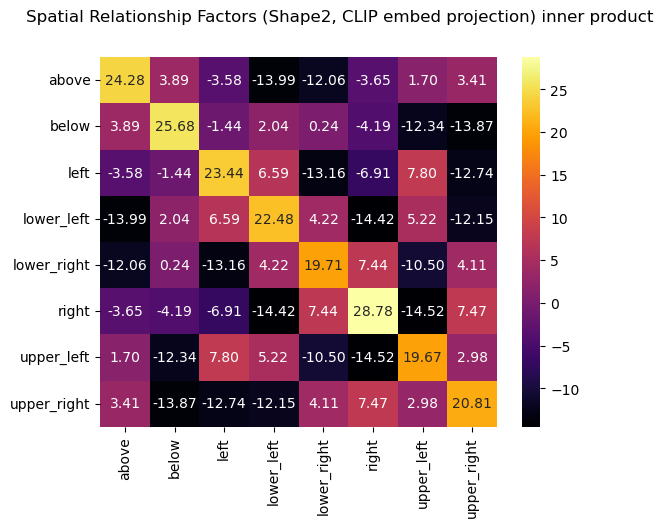

In [ ]:
feat_vecs = effect_vecs["spatial_relationship"]
feat_names = levels_map["spatial_relationship"]
sns.heatmap(feat_vecs@feat_vecs.T, cmap="inferno", annot=True, fmt=".2f", 
            xticklabels=feat_names, yticklabels=feat_names)
plt.suptitle("Spatial Relationship Factorsinner product\n (Shape2, CLIP embed projection) ")
plt.show()

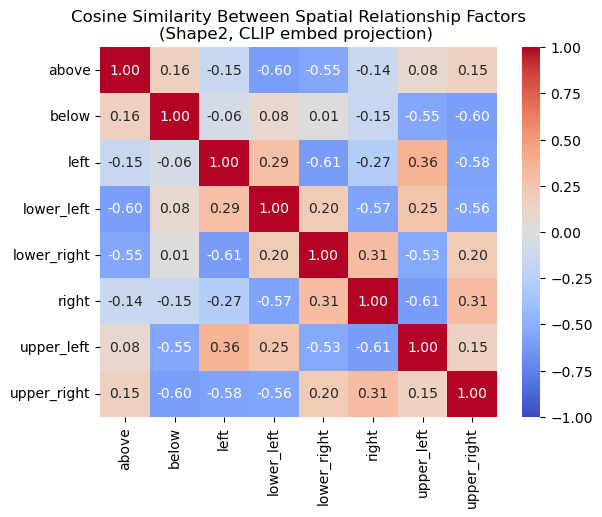

In [123]:
feat_vecs = effect_vecs["spatial_relationship"]
feat_names = levels_map["spatial_relationship"]
# Normalize each feature vector to unit length for cosine similarity
normed_feat_vecs = feat_vecs / np.linalg.norm(feat_vecs, axis=1, keepdims=True)
cosine_mat = normed_feat_vecs @ normed_feat_vecs.T
sns.heatmap(cosine_mat, cmap="coolwarm", annot=True, fmt=".2f",
            xticklabels=feat_names, yticklabels=feat_names, vmin=-1, vmax=1)
plt.title("Cosine Similarity Between Spatial Relationship Factors\n(Shape2, CLIP embed projection) ")
plt.show()

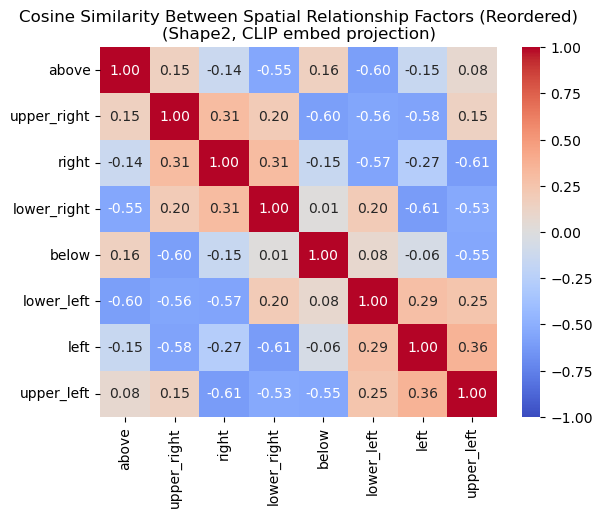

In [124]:
feat_vecs = effect_vecs["spatial_relationship"]
feat_names = levels_map["spatial_relationship"]

# Define the desired ordering of feat_names
desired_order = [
    "above", "upper_right", "right", "lower_right", "below", 
    "lower_left", "left", "upper_left"
]
# Create lookup mapping from feat_names to indices
feat_name_to_idx = {name: i for i, name in enumerate(feat_names)}
reorder_indices = [feat_name_to_idx[name] for name in desired_order if name in feat_name_to_idx]

# Reorder the vectors and names
feat_vecs_ordered = feat_vecs[reorder_indices]
feat_names_ordered = [feat_names[i] for i in reorder_indices]

# Normalize and compute cosine similarity for the reordered vectors
normed_feat_vecs = feat_vecs_ordered / np.linalg.norm(feat_vecs_ordered, axis=1, keepdims=True)
cosine_mat = normed_feat_vecs @ normed_feat_vecs.T
sns.heatmap(
    cosine_mat, cmap="coolwarm", annot=True, fmt=".2f",
    xticklabels=feat_names_ordered, yticklabels=feat_names_ordered, vmin=-1, vmax=1
)
plt.title("Cosine Similarity Between Spatial Relationship Factors (Reordered)\n(Shape2, CLIP embed projection)")
plt.show()

In [127]:
pipeline.text_encoder

CLIPTextModelWithProjection(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 1280)
      (position_embedding): Embedding(77, 1280)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-31): 32 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
          )
          (layer_norm1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1280, out_features=5120, bias=True)
            (fc2): Linear(in_features=5120, out_features=1280, bias=True)
          )
          (layer_norm2): La

In [131]:
import inspect
print(inspect.getsource(pipeline.text_encoder.text_model.encoder.layers[0].self_attn.forward))
print(pipeline.text_encoder.text_model.encoder.layers[0].self_attn.is_causal)

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        causal_attention_mask: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = False,
    ) -> tuple[torch.Tensor, Optional[torch.Tensor]]:
        """Input shape: Batch x Time x Channel"""

        batch_size, seq_length, embed_dim = hidden_states.shape

        queries = self.q_proj(hidden_states)
        keys = self.k_proj(hidden_states)
        values = self.v_proj(hidden_states)

        queries = queries.view(batch_size, seq_length, -1, self.head_dim).transpose(1, 2)
        keys = keys.view(batch_size, seq_length, -1, self.head_dim).transpose(1, 2)
        values = values.view(batch_size, seq_length, -1, self.head_dim).transpose(1, 2)
        # CLIP text model uses both `causal_attention_mask` and `attention_mask`
        # in case FA2 kernel is called, `is_causal` should be inferred from `causal_attention_mask`
        if self.con

### Factor 

In [22]:
effect_vecs["spatial_relationship"].shape

(8, 384)

In [23]:
levels_map["spatial_relationship"]

array(['above', 'below', 'left', 'lower_left', 'lower_right', 'right',
       'upper_left', 'upper_right'], dtype=object)

In [25]:
target_embedding_direction = effect_vecs["spatial_relationship"][levels_map["spatial_relationship"]=="above", :]

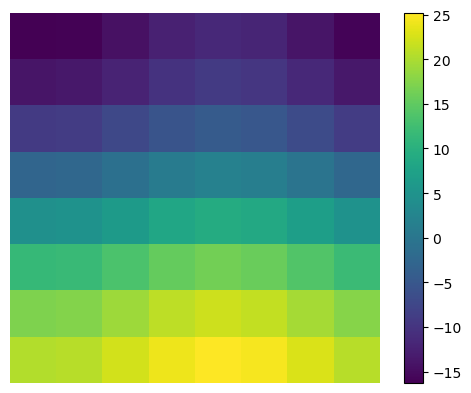

In [40]:
hidden_size = 384
head_num = 6
base_size = 16 // 2
head_dim = hidden_size // head_num
layer_idx = 0
head_idx = 5
device = "cuda"
target_embedding_direction = effect_vecs["spatial_relationship"][levels_map["spatial_relationship"]=="below", :]
target_embedding_direction = torch.from_numpy(target_embedding_direction)[None, :].half().to(device)
word_embed_2k = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_k(target_embedding_direction)
word_embed_2k_h8 = word_embed_2k[0, :, head_idx*head_dim:(head_idx+1)*head_dim]
pos_embed = get_2d_sincos_pos_embed(hidden_size, (base_size, base_size), base_size=base_size)
pos_embed = torch.from_numpy(pos_embed).unsqueeze(0).to(torch.float32).to(device)
pos_embed_2q = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_q(pos_embed.half().cuda())
pos_embed_2q_h8 = pos_embed_2q[0, :, head_idx*head_dim:(head_idx+1)*head_dim]
inner_prod_mat = pos_embed_2q_h8 @ word_embed_2k_h8.T

attn_score = inner_prod_mat[:, 0]
plt.imshow(attn_score.view(8, 8).detach().cpu().numpy())
plt.axis("off")
plt.colorbar()

### Systematic quantification

In [57]:
from circuit_toolkit.plot_utils import saveallforms
figdir = f"/n/home12/binxuwang/Github/DiffusionObjectRelation/Figures/DiT_CLIP_L0H5_L0H2_dissection"

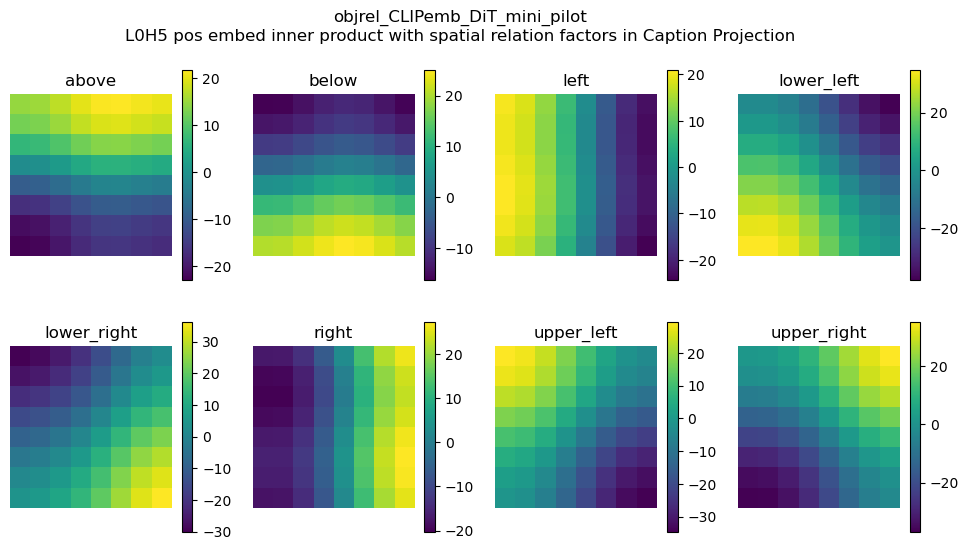

In [58]:
hidden_size = 384
head_num = 6
base_size = 16 // 2
head_dim = hidden_size // head_num
layer_idx = 0
head_idx = 5
device = "cuda"
target_embedding_direction = effect_vecs["spatial_relationship"][:, :]
target_embedding_direction = torch.from_numpy(target_embedding_direction)[None, :].half().to(device)
word_embed_2k = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_k(target_embedding_direction)
word_embed_2k_h8 = word_embed_2k[0, :, head_idx*head_dim:(head_idx+1)*head_dim]
pos_embed = get_2d_sincos_pos_embed(hidden_size, (base_size, base_size), base_size=base_size)
pos_embed = torch.from_numpy(pos_embed).unsqueeze(0).to(torch.float32).to(device)
pos_embed_2q = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_q(pos_embed.half().cuda())
pos_embed_2q_h8 = pos_embed_2q[0, :, head_idx*head_dim:(head_idx+1)*head_dim]
inner_prod_mat = pos_embed_2q_h8 @ word_embed_2k_h8.T

fig, axs = plt.subplots(2, 4, figsize=(12, 6))
axs = axs.flatten()
for i_word in range(len(effect_vecs["spatial_relationship"])):
    plt.sca(axs[i_word])
    attn_score = inner_prod_mat[:, i_word:i_word+1]
    plt.imshow(attn_score.view(8, 8).detach().cpu().numpy())
    plt.title(f"{levels_map['spatial_relationship'][i_word]}")
    plt.axis("off")
    plt.colorbar()
plt.suptitle(f"{run_name}\nL{layer_idx}H{head_idx} pos embed inner product with spatial relation factors in Caption Projection")
saveallforms(figdir, f"{run_name}_L{layer_idx}H{head_idx}_pos_embed_inprod_with_rel_factors_proj")

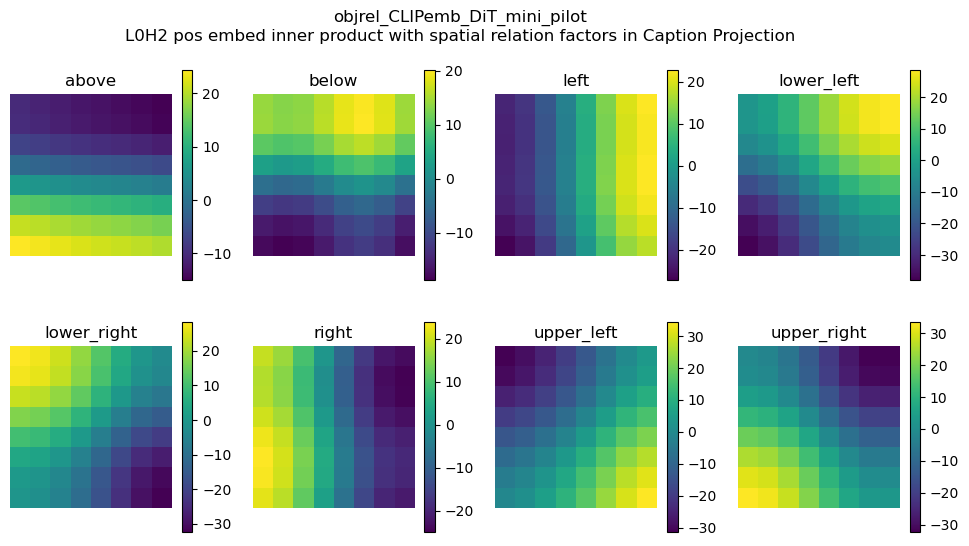

In [59]:
hidden_size = 384
head_num = 6
base_size = 16 // 2
head_dim = hidden_size // head_num
layer_idx = 0
head_idx = 2
device = "cuda"
target_embedding_direction = effect_vecs["spatial_relationship"][:, :]
target_embedding_direction = torch.from_numpy(target_embedding_direction)[None, :].half().to(device)
word_embed_2k = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_k(target_embedding_direction)
word_embed_2k_h8 = word_embed_2k[0, :, head_idx*head_dim:(head_idx+1)*head_dim]
pos_embed = get_2d_sincos_pos_embed(hidden_size, (base_size, base_size), base_size=base_size)
pos_embed = torch.from_numpy(pos_embed).unsqueeze(0).to(torch.float32).to(device)
pos_embed_2q = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_q(pos_embed.half().cuda())
pos_embed_2q_h8 = pos_embed_2q[0, :, head_idx*head_dim:(head_idx+1)*head_dim]
inner_prod_mat = pos_embed_2q_h8 @ word_embed_2k_h8.T

fig, axs = plt.subplots(2, 4, figsize=(12, 6))
axs = axs.flatten()
for i_word in range(len(effect_vecs["spatial_relationship"])):
    plt.sca(axs[i_word])
    attn_score = inner_prod_mat[:, i_word:i_word+1]
    plt.imshow(attn_score.view(8, 8).detach().cpu().numpy())
    plt.title(f"{levels_map['spatial_relationship'][i_word]}")
    plt.axis("off")
    plt.colorbar()
plt.suptitle(f"{run_name}\nL{layer_idx}H{head_idx} pos embed inner product with spatial relation factors in Caption Projection")
saveallforms(figdir, f"{run_name}_L{layer_idx}H{head_idx}_pos_embed_inprod_with_rel_factors_proj")

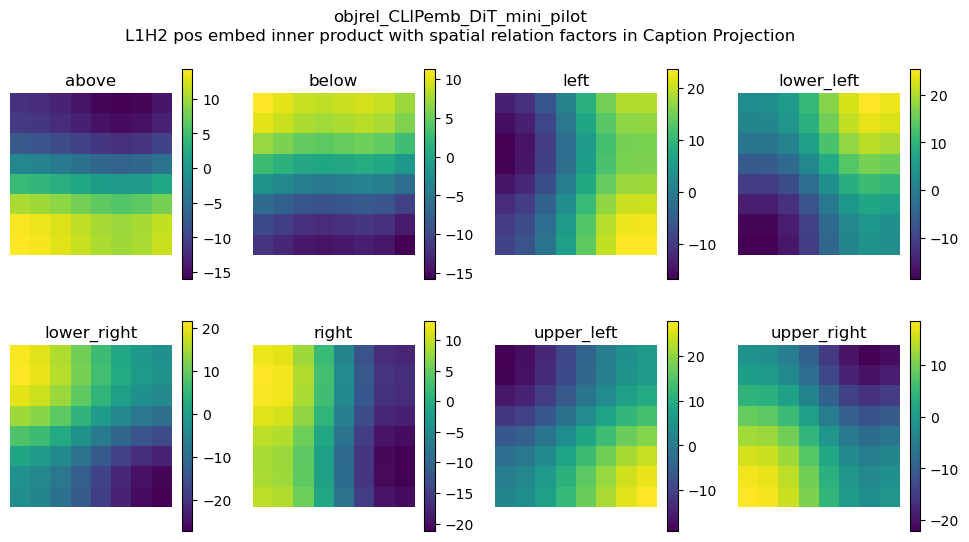

In [60]:
hidden_size = 384
head_num = 6
base_size = 16 // 2
head_dim = hidden_size // head_num
layer_idx = 1
head_idx = 2
device = "cuda"
target_embedding_direction = effect_vecs["spatial_relationship"][:, :]
target_embedding_direction = torch.from_numpy(target_embedding_direction)[None, :].half().to(device)
word_embed_2k = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_k(target_embedding_direction)
word_embed_2k_h8 = word_embed_2k[0, :, head_idx*head_dim:(head_idx+1)*head_dim]
pos_embed = get_2d_sincos_pos_embed(hidden_size, (base_size, base_size), base_size=base_size)
pos_embed = torch.from_numpy(pos_embed).unsqueeze(0).to(torch.float32).to(device)
pos_embed_2q = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_q(pos_embed.half().cuda())
pos_embed_2q_h8 = pos_embed_2q[0, :, head_idx*head_dim:(head_idx+1)*head_dim]
inner_prod_mat = pos_embed_2q_h8 @ word_embed_2k_h8.T

fig, axs = plt.subplots(2, 4, figsize=(12, 6))
axs = axs.flatten()
for i_word in range(len(effect_vecs["spatial_relationship"])):
    plt.sca(axs[i_word])
    attn_score = inner_prod_mat[:, i_word:i_word+1]
    plt.imshow(attn_score.view(8, 8).detach().cpu().numpy())
    plt.title(f"{levels_map['spatial_relationship'][i_word]}")
    plt.axis("off")
    plt.colorbar()
plt.suptitle(f"{run_name}\nL{layer_idx}H{head_idx} pos embed inner product with spatial relation factors in Caption Projection")
saveallforms(figdir, f"{run_name}_L{layer_idx}H{head_idx}_pos_embed_inprod_with_rel_factors_proj")


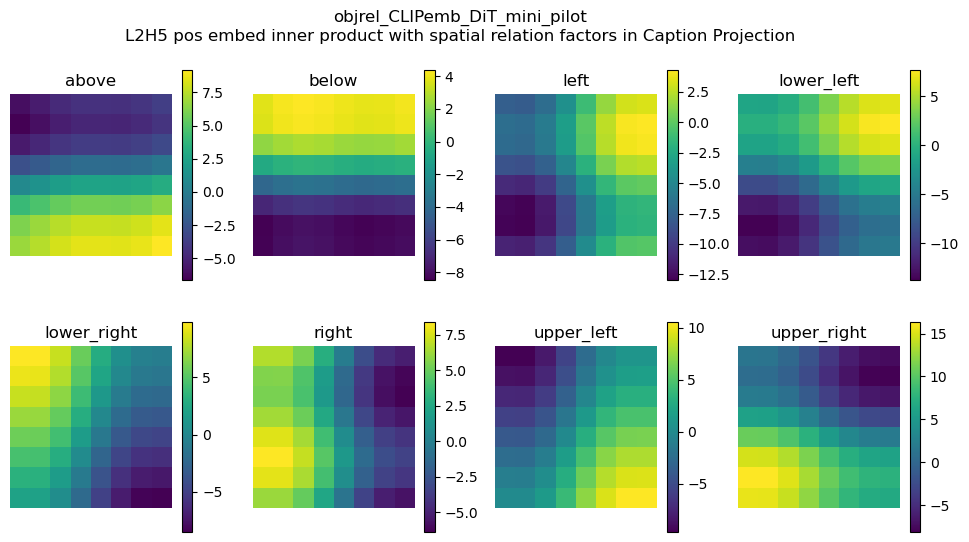

In [61]:
hidden_size = 384
head_num = 6
base_size = 16 // 2
head_dim = hidden_size // head_num
layer_idx = 2
head_idx = 5
device = "cuda"
target_embedding_direction = effect_vecs["spatial_relationship"][:, :]
target_embedding_direction = torch.from_numpy(target_embedding_direction)[None, :].half().to(device)
word_embed_2k = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_k(target_embedding_direction)
word_embed_2k_h8 = word_embed_2k[0, :, head_idx*head_dim:(head_idx+1)*head_dim]
pos_embed = get_2d_sincos_pos_embed(hidden_size, (base_size, base_size), base_size=base_size)
pos_embed = torch.from_numpy(pos_embed).unsqueeze(0).to(torch.float32).to(device)
pos_embed_2q = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_q(pos_embed.half().cuda())
pos_embed_2q_h8 = pos_embed_2q[0, :, head_idx*head_dim:(head_idx+1)*head_dim]
inner_prod_mat = pos_embed_2q_h8 @ word_embed_2k_h8.T

fig, axs = plt.subplots(2, 4, figsize=(12, 6))
axs = axs.flatten()
for i_word in range(len(effect_vecs["spatial_relationship"])):
    plt.sca(axs[i_word])
    attn_score = inner_prod_mat[:, i_word:i_word+1]
    plt.imshow(attn_score.view(8, 8).detach().cpu().numpy())
    plt.title(f"{levels_map['spatial_relationship'][i_word]}")
    plt.axis("off")
    plt.colorbar()
plt.suptitle(f"{run_name}\nL{layer_idx}H{head_idx} pos embed inner product with spatial relation factors in Caption Projection")
saveallforms(figdir, f"{run_name}_L{layer_idx}H{head_idx}_pos_embed_inprod_with_rel_factors_proj")


In [143]:
from utils.pixart_utils import PixArt_model_configs
def compute_vis_pos_embed_inner_prod(pipeline, config, layer_idx, head_idx, feature_vecs, levels_names=None, 
                                   model_run_name="model", device="cuda", visualize=True):
    """
    Visualize the inner product between 2D positional embeddings and target effect vectors for specified head/layer.

    Args:
        layer_idx: int, transformer block index (layer)
        head_idx: int, attention head index
        pipeline: model pipeline with .transformer.transformer_blocks
        effect_vecs: dict of [feature_name] -> np.ndarray (n_level, embed_dim)
        feature: str, which effect_vecs key to use (default: "spatial_relationship")
        model_run_name: str, for titling plots
        levels_map: dict of [feature] -> list of level names (labels for plot)
        device: str, torch device

    Returns: None (creates plot)
    """
    # Get model size info
    transformer_config = PixArt_model_configs[config.model] if config is not None else PixArt_model_configs["PixArt_B_2"]
    hidden_size = transformer_config["hidden_size"]
    head_num = transformer_config["num_heads"]
    layer_num = transformer_config["depth"]
    base_size = 16 // 2
    head_dim = hidden_size // head_num

    # Target embedding direction
    target_embedding_direction = feature_vecs[:, :]
    target_embedding_direction = torch.from_numpy(target_embedding_direction)[None, :].half().to(device)
    word_embed_2k = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_k(target_embedding_direction)
    word_embed_2k_h = word_embed_2k[0, :, head_idx*head_dim:(head_idx+1)*head_dim]

    # Positional encoding
    pos_embed = get_2d_sincos_pos_embed(hidden_size, (base_size, base_size), base_size=base_size)
    pos_embed = torch.from_numpy(pos_embed).unsqueeze(0).to(torch.float32).to(device)
    pos_embed_2q = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_q(pos_embed.half().to(device))
    pos_embed_2q_h = pos_embed_2q[0, :, head_idx*head_dim:(head_idx+1)*head_dim]

    inner_prod_mat = pos_embed_2q_h @ word_embed_2k_h.T
    if visualize:
        num_levels = len(feature_vecs)
        nrows, ncols = (2, 4) if num_levels == 8 else (1, num_levels)
        fig, axs = plt.subplots(nrows, ncols, figsize=(12, 6))
        axs = axs.flatten() if hasattr(axs, "flatten") else [axs]

        for i_word in range(num_levels):
            plt.sca(axs[i_word])
            attn_score = inner_prod_mat[:, i_word:i_word+1]
            plt.imshow(attn_score.view(8, 8).detach().cpu().numpy())
            if levels_names is not None:
                plt.title(f"{levels_names[i_word]}")
            else:
                plt.title(f"{i_word}")
            plt.axis("off")
            plt.colorbar()
        plt.suptitle(f"{model_run_name}\nL{layer_idx}H{head_idx} pos embed inner product with {len(feature_vecs)} factors in Caption Projection")
        # Optionally, save: saveallforms(figdir, f"{model_run_name}_L{layer_idx}H{head_idx}_pos_embed_inprod_with_{feature}_proj")
        plt.tight_layout()
        plt.show()
    return inner_prod_mat
# Example call (replace indices and other vars as needed):
# 

### quantification and scoring

In [62]:
levels_map["spatial_relationship"]

array(['above', 'below', 'left', 'lower_left', 'lower_right', 'right',
       'upper_left', 'upper_right'], dtype=object)

In [96]:
import numpy as np
def ramp_alignment_metrics(M, dvec, eps=1e-12):
    """
    Returns:
      cosine     : [-1, 1] alignment with spatial direction (scale-free)
      projection : signed magnitude of alignment (units of M)
    """
    H, W = M.shape
    d = np.array(dvec)
    d = d / np.linalg.norm(d)
    
    # coordinate grid
    xs = np.linspace(-1, 1, W)
    ys = np.linspace(-1, 1, H)
    X, Y = np.meshgrid(xs, ys)

    # ramp template
    T = d[0] * X + d[1] * Y
    T = T - T.mean()                      # remove DC (important!)
    T_norm = np.linalg.norm(T) + eps
    T_unit = T / T_norm                   # unit template

    # centered map
    # A = M.astype(float)
    A = M - M.mean()
    A_norm = np.linalg.norm(A) + eps

    # (1) signed projection magnitude
    projection = np.sum(A * T / T_norm)

    # (2) cosine / correlation
    cosine = projection / A_norm

    return dict(
        cosine=cosine,
        projection=projection,
        energy=A_norm,
        template_norm=T_norm,
    )

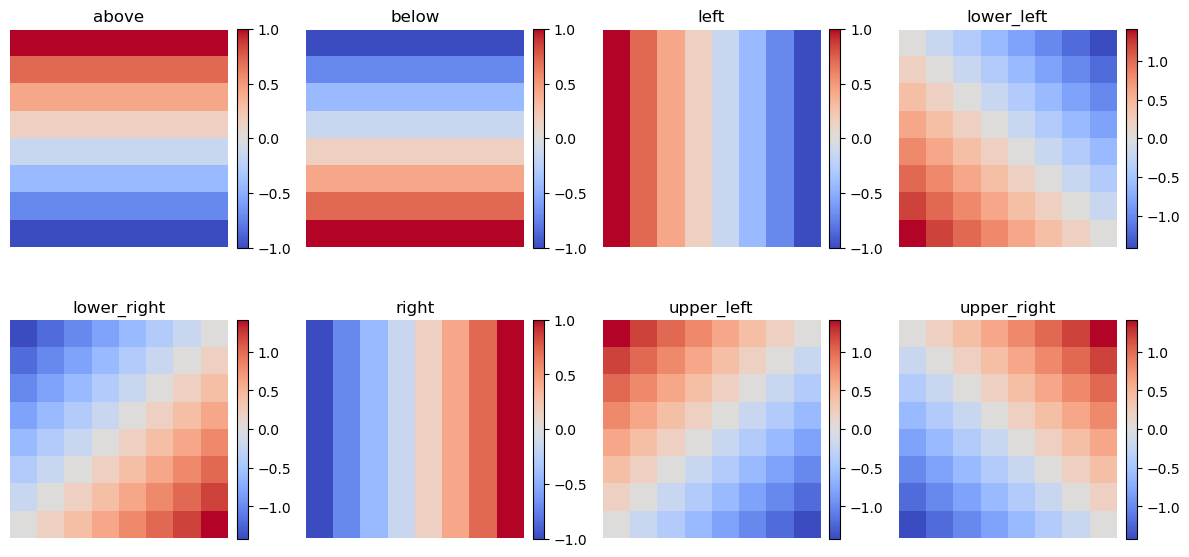

In [132]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_direction_vectors(H=8, W=8):
    direction_vector = {
        'above': [0, -1],
        'below': [0, 1],
        'left': [-1, 0],
        'lower_left': [-1, 1],
        'lower_right': [1, 1],
        'right': [1, 0],
        'upper_left': [-1, -1],
        'upper_right': [1, -1]
    }

    # Visualize the template ramps in 2x4 subplots
    H, W = 8, 8  # set the dimensions of the grid (adjust if appropriate)
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    for idx, (name, dvec) in enumerate(direction_vector.items()):
        xs = np.linspace(-1, 1, W)
        ys = np.linspace(-1, 1, H)
        X, Y = np.meshgrid(xs, ys)
        d = np.array(dvec)
        d = d / np.linalg.norm(d)
        T = d[0] * X + d[1] * Y
        T = T - T.mean()
        
        ax = axes[idx // 4, idx % 4]
        im = ax.imshow(T, cmap='coolwarm')
        ax.set_title(name)
        ax.axis('off')
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

visualize_direction_vectors()

In [97]:
# inner_prod_mat[:, i_word:i_word+1].view(8, 8)
# plt.imshow(attn_score.view(8, 8).detach().cpu().numpy())
# plt.title(f"{levels_map['spatial_relationship'][i_word]}")
def eval_ramp_alignment_all(inner_prod_mat, spatial_relationship_levels, eps=1e-12):
    direction_vector = {
        'above': [0, -1],
        'below': [0, 1],
        'left': [-1, 0],
        'lower_left': [-1, 1],
        'lower_right': [1, 1],
        'right': [1, 0],
        'upper_left': [-1, -1],
        'upper_right': [1, -1]
    }

    i_word = 1
    align_dict_list = []
    for i_word in range(len(spatial_relationship_levels)):
        rel_name = spatial_relationship_levels[i_word]
        dvec = direction_vector[rel_name]
        align_dict = ramp_alignment_metrics(inner_prod_mat[:, i_word:i_word+1].view(8, 8).detach().cpu().numpy(), dvec, eps=1e-12)
        align_dict["rel_name"] = rel_name
        align_dict["dvec"] = (dvec[0], dvec[1])
        align_dict["dir_idx"] = i_word
        align_dict_list.append(align_dict)
    # align_dict_list
    align_df = pd.DataFrame(align_dict_list)
    return align_df

In [83]:
align_df = eval_ramp_alignment_all(inner_prod_mat, levels_map["spatial_relationship"])
align_df


,cosine,projection,energy,template_norm,rel_name,dvec,dir_idx
0,-0.962978,-213.396275,42.31250,5.237229,above,"(0, -1)",0
1,-0.973544,-203.150251,39.84375,5.237229,below,"(0, 1)",1
2,-0.864920,-183.739397,40.56250,5.237229,left,"(-1, 0)",2
3,-0.930848,-242.991405,49.84375,5.237229,lower_left,"(-1, 1)",3
4,-0.960877,-201.293315,40.00000,5.237229,lower_right,"(1, 1)",4
5,-0.957693,-190.908552,38.06250,5.237229,right,"(1, 0)",5
6,-0.976127,-223.179443,43.65625,5.237229,upper_left,"(-1, -1)",6
7,-0.928103,-279.337562,57.46875,5.237229,upper_right,"(1, -1)",7


In [98]:
from tqdm import tqdm
from itertools import product
hidden_size = 384
head_num = 6
base_size = 16 // 2
head_dim = hidden_size // head_num
# layer_idx = 2
# head_idx = 5
align_df_list = []
for layer_idx, head_idx in tqdm(product(range(6), range(6))):
        device = "cuda"
        target_embedding_direction = effect_vecs["spatial_relationship"][:, :]
        target_embedding_direction = torch.from_numpy(target_embedding_direction)[None, :].half().to(device)
        word_embed_2k = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_k(target_embedding_direction)
        word_embed_2k_h8 = word_embed_2k[0, :, head_idx*head_dim:(head_idx+1)*head_dim]
        pos_embed = get_2d_sincos_pos_embed(hidden_size, (base_size, base_size), base_size=base_size)
        pos_embed = torch.from_numpy(pos_embed).unsqueeze(0).to(torch.float32).to(device)
        pos_embed_2q = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_q(pos_embed.half().cuda())
        pos_embed_2q_h8 = pos_embed_2q[0, :, head_idx*head_dim:(head_idx+1)*head_dim]
        inner_prod_mat = pos_embed_2q_h8 @ word_embed_2k_h8.T
        align_df = eval_ramp_alignment_all(inner_prod_mat, levels_map["spatial_relationship"])
        align_df["layer_idx"] = layer_idx
        align_df["head_idx"] = head_idx
        align_df_list.append(align_df)
align_df_allheads = pd.concat(align_df_list)

36it [00:00, 454.97it/s]


In [99]:
align_df_allheads.to_csv(join(figdir, f"{run_name}_all_heads_align_df.csv"), index=False)
align_df_allheads.to_pickle(join(figdir, f"{run_name}_all_heads_align_df.pkl"))

In [100]:
align_df_allheads.groupby(["layer_idx", "head_idx"]).mean(numeric_only=True)

cosine  projection      energy  template_norm  dir_idx
layer_idx head_idx                                                          
0         0        -0.146129   -4.216084   35.109375       5.237229      3.5
          1         0.357555   16.813122   39.248047       5.237229      3.5
          2        -0.981441 -124.589839  126.843750       5.237229      3.5
          3        -0.317242  -13.777322   39.757813       5.237229      3.5
          4         0.650110   36.920378   56.554688       5.237229      3.5
          5         0.983762  129.291515  131.390625       5.237229      3.5
1         0        -0.623131  -21.740667   34.705078       5.237229      3.5
          1        -0.223044  -14.735901   45.211914       5.237229      3.5
          2        -0.975478  -89.612111   91.890625       5.237229      3.5
          3         0.867758   41.007968   46.957031       5.237229      3.5
          4        -0.700392  -20.613664   27.972656       5.237229      3.5
          5         0.360948   18.803417   42.741211       5.237229      3.5
2         0        -0.598843  -20.078867   29.753906       5.237229      3.5
          1        -0.782754  -14.085776   17.897461       5.237229      3.5
          2        -0.627681  -12.705861   20.125977       5.237229      3.5
          3         0.163742    2.114671   13.892090       5.237229      3.5
          4        -0.589712   -9.732887   15.911133       5.237229      3.5
          5        -0.944386  -41.481766   43.968750       5.237229      3.5
3         0        -0.681416  -18.163338   25.033203       5.237229      3.5
          1        -0.709106  -13.416833   18.450195       5.237229      3.5
          2         0.381571    2.349275    8.390137       5.237229      3.5
          3        -0.099759   -0.374418    8.247559       5.237229      3.5
          4        -0.668317  -15.109317   20.553711       5.237229      3.5
          5        -0.445468   -5.247985    9.775146       5.237229      3.5
4         0        -0.088669   -0.701693    8.563477       5.237229      3.5
          1        -0.724801   -7.521493   10.285645       5.237229      3.5
          2        -0.468193   -6.246940   10.940430       5.237229      3.5
          3        -0.505765   -4.171476    7.520996       5.237229      3.5
          4        -0.772517   -7.918800   10.214355       5.237229      3.5
          5        -0.327425   -3.602084   10.818359       5.237229      3.5
5         0         0.410415    4.377976    9.756348       5.237229      3.5
          1        -0.140640   -1.571250    7.860840       5.237229      3.5
          2        -0.211050   -2.436275   11.649414       5.237229      3.5
          3        -0.231190   -4.189248   10.237793       5.237229      3.5
          4        -0.452103   -4.371890    8.459473       5.237229      3.5
          5         0.046558    0.753283   10.137207       5.237229      3.5

In [101]:
align_df_allheads.query("layer_idx == 0 & head_idx == 2")

,cosine,projection,energy,template_norm,rel_name,dvec,dir_idx,layer_idx,head_idx
0,-0.974814,-102.477300,105.125,5.237229,above,"(0, -1)",0,0,2
1,-0.962926,-97.616638,101.375,5.237229,below,"(0, 1)",1,0,2
2,-0.986073,-131.147673,133.000,5.237229,left,"(-1, 0)",2,0,2
3,-0.983025,-139.343798,141.750,5.237229,lower_left,"(-1, 1)",3,0,2
4,-0.986688,-127.159390,128.875,5.237229,lower_right,"(1, 1)",4,0,2
5,-0.980543,-127.715790,130.250,5.237229,right,"(1, 0)",5,0,2
6,-0.991629,-131.886720,133.000,5.237229,upper_left,"(-1, -1)",6,0,2
7,-0.985828,-139.371402,141.375,5.237229,upper_right,"(1, -1)",7,0,2


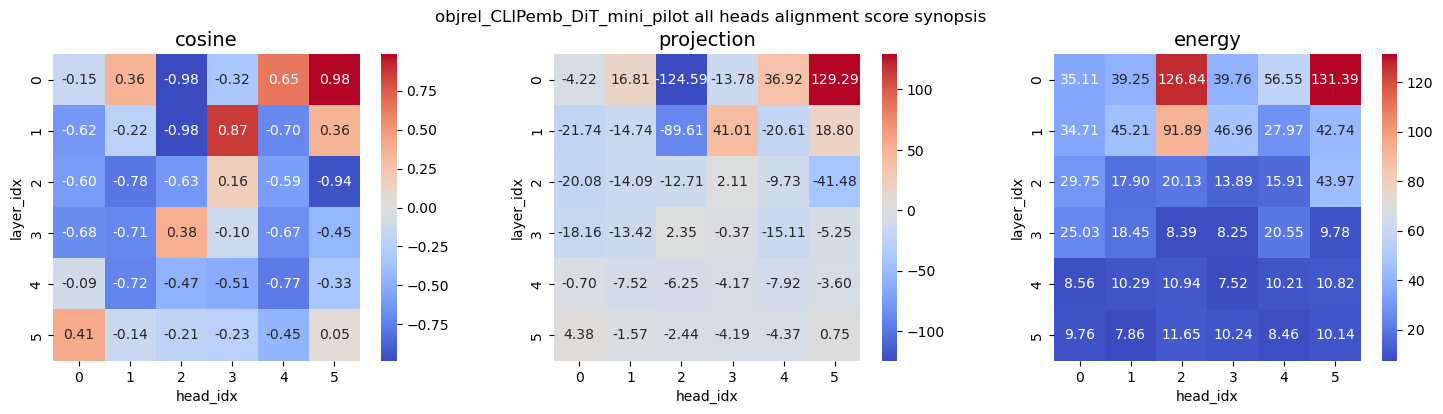

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns


head_align_synopsis = align_df_allheads.groupby(["layer_idx", "head_idx"]).mean(numeric_only=True)
# Plot each column in head_align_synopsis as a heatmap (layers x heads)
metrics = ["cosine", "projection", "energy", ]
n_metrics = len(metrics)
fig, axes = plt.subplots(1, n_metrics, figsize=(5*n_metrics, 4), squeeze=False)
for idx, metric in enumerate(metrics):
    # reshape values into 2D (layer, head)
    heatmap_data = head_align_synopsis[metric].unstack(level="head_idx")
    ax = axes[0, idx]
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="coolwarm", ax=ax, cbar=True)
    ax.set_aspect("equal")
    ax.set_title(metric, fontsize=14)
    ax.set_xlabel("head_idx")
    ax.set_ylabel("layer_idx")
plt.suptitle(f"{run_name} all heads alignment score synopsis")
plt.tight_layout()
saveallforms(figdir, f"{run_name}_all_heads_align_score_synopsis")
plt.show()

### Effect of adding the?

In [133]:
from easydict import EasyDict as edict
def compute_shape_wordvecs_and_project(
    pipeline, 
    prompt_template="{color1} {shape1} is {rel_text} {color2} {shape2}",
    max_sequence_length=20, 
    device="cuda"
):
    dataset_tmp = ShapesDataset(num_images=10000)
    prompt_collection_all, scene_info_collection_all = generate_all_prompt_collection(
        dataset_tmp.spatial_phrases,
        prompt_template=prompt_template,
    )
    embedding_allrel_allobj = precompute_embeddings(
        {"base": (prompt_collection_all, scene_info_collection_all)}, 
        pipeline.tokenizer, pipeline.text_encoder, 
        max_sequence_length=max_sequence_length, device=device
    )
    prompt_scene_info_all_df = pd.DataFrame(scene_info_collection_all)
    prompt_scene_info_all_df["prompt"] = prompt_collection_all

    wordvec_obj1_col = []
    wordvec_obj2_col = []
    for row in prompt_scene_info_all_df.itertuples():
        tokenized = pipeline.tokenizer(
            row.prompt, max_length=max_sequence_length, padding="max_length", truncation=True, return_tensors="pt"
        )
        token_ids = tokenized['input_ids'][0]
        tokens = [pipeline.tokenizer.decode([token_id]) for token_id in token_ids]

        shape1_mask_idx = find_shape_index(tokens, row.shape1)
        shape2_mask_idx = find_shape_index(tokens, row.shape2)
        cap_embeds = embedding_allrel_allobj[f"base::{row.prompt}"]['caption_embeds']
        if shape1_mask_idx is None or shape2_mask_idx is None:
            print(f"Prompt: {row.prompt}")
            print(f"Shape1 ({row.shape1}) at index: {shape1_mask_idx}")
            print(f"Shape2 ({row.shape2}) at index: {shape2_mask_idx}")
            print("---")
            raise ValueError("Shape index not found")
        wordvec_obj1_col.append(cap_embeds[0, shape1_mask_idx, :])
        wordvec_obj2_col.append(cap_embeds[0, shape2_mask_idx, :])
    wordvec_obj1_mat = torch.stack(wordvec_obj1_col, dim=0)
    wordvec_obj2_mat = torch.stack(wordvec_obj2_col, dim=0)
    with torch.no_grad():
        wordvec_obj1_mat_proj = pipeline.transformer.caption_projection(wordvec_obj1_mat.half().cuda())
        wordvec_obj2_mat_proj = pipeline.transformer.caption_projection(wordvec_obj2_mat.half().cuda())
    return edict({
        "prompt_scene_info_all_df": prompt_scene_info_all_df,
        "wordvec_obj1_mat": wordvec_obj1_mat,
        "wordvec_obj2_mat": wordvec_obj2_mat,
        "wordvec_obj1_mat_proj": wordvec_obj1_mat_proj,
        "wordvec_obj2_mat_proj": wordvec_obj2_mat_proj,
    })

# Example call (optional, you may uncomment in your notebook):
# result = compute_shape_wordvecs_and_project(pipeline)
# prompt_scene_info_all_df = result["prompt_scene_info_all_df"]
# wordvec_obj1_mat = result["wordvec_obj1_mat"]
# wordvec_obj2_mat = result["wordvec_obj2_mat"]
# wordvec_obj1_mat_proj = result["wordvec_obj1_mat_proj"]
# wordvec_obj2_mat_proj = result["wordvec_obj2_mat_proj"]

In [134]:
original_wordvecs = compute_shape_wordvecs_and_project(pipeline, prompt_template="{color1} {shape1} is {rel_text} {color2} {shape2}", )
the1_wordvecs = compute_shape_wordvecs_and_project(pipeline, prompt_template="the {color1} {shape1} is {rel_text} {color2} {shape2}", )
the2_wordvecs = compute_shape_wordvecs_and_project(pipeline, prompt_template="{color1} {shape1} is {rel_text} the {color2} {shape2}", )
the12_wordvecs = compute_shape_wordvecs_and_project(pipeline, prompt_template="the {color1} {shape1} is {rel_text} the {color2} {shape2}", )

Pre-computing text embeddings for all prompts...
Computing unconditional embedding...


Computing embeddings:   0%|          | 0/265 [00:00<?, ?it/s]

Cached embeddings for 265 unique prompts (including uncond)
Pre-computing text embeddings for all prompts...
Computing unconditional embedding...


Computing embeddings:   0%|          | 0/265 [00:00<?, ?it/s]

Cached embeddings for 265 unique prompts (including uncond)
Pre-computing text embeddings for all prompts...
Computing unconditional embedding...


Computing embeddings:   0%|          | 0/265 [00:00<?, ?it/s]

Cached embeddings for 265 unique prompts (including uncond)
Pre-computing text embeddings for all prompts...
Computing unconditional embedding...


Computing embeddings:   0%|          | 0/265 [00:00<?, ?it/s]

Cached embeddings for 265 unique prompts (including uncond)


In [138]:
figdir_the = "/n/home12/binxuwang/Github/DiffusionObjectRelation/Figures/DiT_CLIP_the_repr_bias"
pkl.dump(original_wordvecs, open(join(figdir_the, "CLIP_shape12_wordvecs_original.pkl"), "wb"))
pkl.dump(the1_wordvecs, open(join(figdir_the, "CLIP_shape12_wordvecs_the1.pkl"), "wb"))
pkl.dump(the2_wordvecs, open(join(figdir_the, "CLIP_shape12_wordvecs_the2.pkl"), "wb"))
pkl.dump(the12_wordvecs, open(join(figdir_the, "CLIP_shape12_wordvecs_the12.pkl"), "wb"))

In [139]:
prompt_scene_info_all_df["color1shape1"] = prompt_scene_info_all_df["color1"] + "_" + prompt_scene_info_all_df["shape1"]
prompt_scene_info_all_df["color2shape2"] = prompt_scene_info_all_df["color2"] + "_" + prompt_scene_info_all_df["shape2"]
print("shape2, T5 embedding, caption projection")
var_part_df, intercept, effect_vecs, levels_map, R2_total = variance_partition_with_effects(original_wordvecs.wordvec_obj2_mat_proj.float().cpu().numpy(),
            {"spatial_relationship": prompt_scene_info_all_df["spatial_relationship"],
            #  "color1": prompt_scene_info_all_df["color1"],
            #  "shape1": prompt_scene_info_all_df["shape1"],
            #  "color2": prompt_scene_info_all_df["color2"],
             "shape2": prompt_scene_info_all_df["shape2"],
             "color1shape1": prompt_scene_info_all_df["color1shape1"],
            #  "color2shape2": prompt_scene_info_all_df["color2shape2"],
             },
            metric="euclidean",
            n_perm=100)
var_part_df

shape2, T5 embedding, caption projection
Total R2 (all features): 0.502603
Total R² (all features): 0.5026


,feature,levels,df_effect,df_resid,SS_total,SSR_marginal,R2_marginal,SSR_partial,R2_partial,eta2_partial,p_partial_perm
0,color1shape1,6,5,249,34851.527819,7566.671621,0.217112,6615.762368,0.189827,0.276223,0.009901
1,spatial_relationship,8,7,249,34851.527819,6006.954735,0.172358,6006.954735,0.172358,0.257345,0.009901
2,shape2,3,2,249,34851.527819,4893.768825,0.140418,3942.859572,0.113133,0.185303,0.009901


In [137]:
the1_pert_vecs = the1_wordvecs.wordvec_obj2_mat_proj - original_wordvecs.wordvec_obj2_mat_proj 
the1_pert_vecs_mean = the1_pert_vecs.mean(dim=0)
the2_pert_vecs = the2_wordvecs.wordvec_obj2_mat_proj - original_wordvecs.wordvec_obj2_mat_proj 
the2_pert_vecs_mean = the2_pert_vecs.mean(dim=0)
the12_pert_vecs = the12_wordvecs.wordvec_obj2_mat_proj - original_wordvecs.wordvec_obj2_mat_proj 
the12_pert_vecs_mean = the12_pert_vecs.mean(dim=0)

In [142]:
import torch
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
# Get the spatial relationship effect vectors and the mean perturbation vector as numpy arrays
spatial_featvecs = effect_vecs["spatial_relationship"]
if isinstance(spatial_featvecs, torch.Tensor):
    spatial_featvecs = spatial_featvecs.float().cpu().numpy()
spatial_featvecs_norm = np.linalg.norm(spatial_featvecs, axis=1)
pert_vec1 = the1_pert_vecs_mean.float().cpu().numpy()[None, :]
pert_vec2 = the2_pert_vecs_mean.float().cpu().numpy()[None, :]
pert_vec12 = the12_pert_vecs_mean.float().cpu().numpy()[None, :]
# Compute cosine similarity between each effect vector and the perturbation vector
cos_sims1 = cosine_similarity(spatial_featvecs, pert_vec1)
inner_prod1 = spatial_featvecs @ pert_vec1.T
cos_sims2 = cosine_similarity(spatial_featvecs, pert_vec2)
inner_prod2 = spatial_featvecs @ pert_vec2.T
cos_sims12 = cosine_similarity(spatial_featvecs, pert_vec12)
inner_prod12 = spatial_featvecs @ pert_vec12.T
spatial_levels = levels_map["spatial_relationship"]
spatial_sim_df = pd.DataFrame({
    "spatial_relation": spatial_levels,
    "vecnorm": spatial_featvecs_norm,
    "cosine[the1]": cos_sims1.flatten(),
    "dotprod[the1]": inner_prod1.flatten(),
    "cosine[the2]": cos_sims2.flatten(),
    "dotprod[the2]": inner_prod2.flatten(),
    "cosine[the12]": cos_sims12.flatten(),
    "dotprod[the12]": inner_prod12.flatten(),
})
display(spatial_sim_df)
spatial_sim_df.to_csv(join(figdir_the, "CLIP_shape12_the_repr_bias_spatial_sim_df.csv"), index=False)

,spatial_relation,vecnorm,cosine[the1],dotprod[the1],cosine[the2],dotprod[the2],cosine[the12],dotprod[the12]
0,above,4.927962,-0.423434,-1.831640,-0.466108,-4.265991,-0.541002,-5.517517
1,below,5.067408,0.014705,0.065411,-0.174311,-1.640504,-0.132773,-1.392426
2,left,4.841628,0.151074,0.642048,-0.208782,-1.877373,-0.082792,-0.829578
3,lower_left,4.741308,0.440591,1.833669,0.259454,2.284674,0.366900,3.600171
4,lower_right,4.439477,0.179191,0.698291,0.469453,3.870700,0.421764,3.875063
5,right,5.364601,-0.280222,-1.319554,0.144090,1.435611,0.014225,0.157935
6,upper_left,4.434681,0.129447,0.503899,-0.118960,-0.979777,-0.039499,-0.362513
7,upper_right,4.561729,-0.147875,-0.592124,0.138413,1.172659,0.049664,0.468866


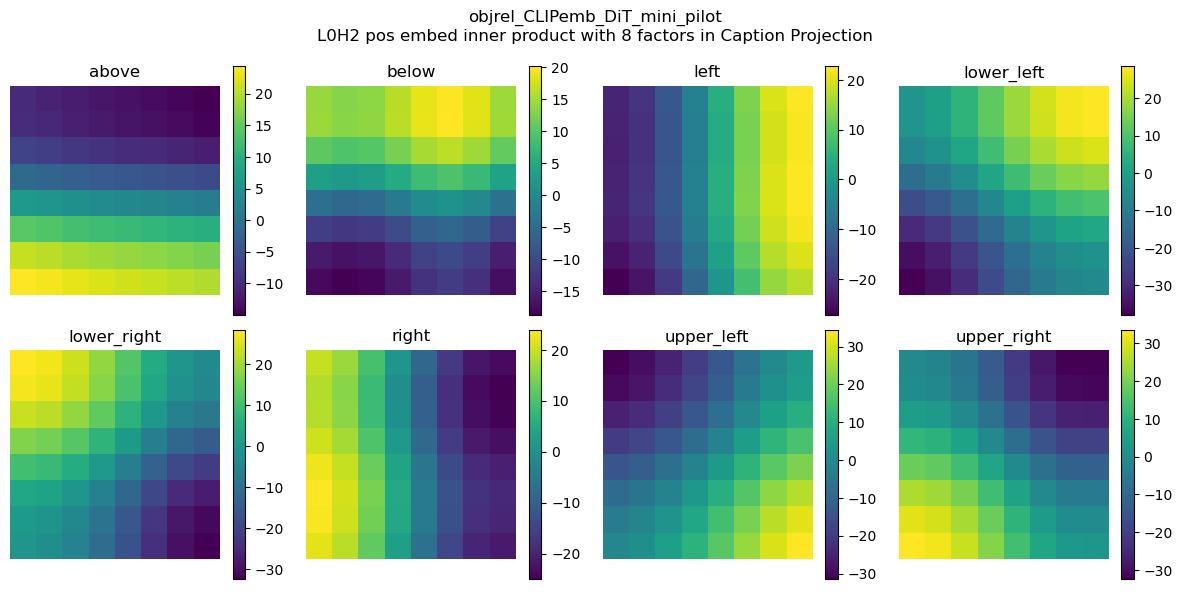

,cosine,projection,energy,template_norm,rel_name,dvec,dir_idx
0,-0.974814,-102.477300,105.125,5.237229,above,"(0, -1)",0
1,-0.962926,-97.616638,101.375,5.237229,below,"(0, 1)",1
2,-0.986073,-131.147673,133.000,5.237229,left,"(-1, 0)",2
3,-0.983025,-139.343798,141.750,5.237229,lower_left,"(-1, 1)",3
4,-0.986688,-127.159390,128.875,5.237229,lower_right,"(1, 1)",4
5,-0.980543,-127.715790,130.250,5.237229,right,"(1, 0)",5
6,-0.991629,-131.886720,133.000,5.237229,upper_left,"(-1, -1)",6
7,-0.985828,-139.371402,141.375,5.237229,upper_right,"(1, -1)",7


In [148]:
inner_prod_mat = compute_vis_pos_embed_inner_prod(pipeline, config, layer_idx=0, head_idx=2, feature_vecs=effect_vecs["spatial_relationship"], 
                                levels_names=levels_map["spatial_relationship"], 
                                model_run_name=run_name, device="cuda", visualize=True);
align_df = eval_ramp_alignment_all(inner_prod_mat, levels_map["spatial_relationship"])
display(align_df)

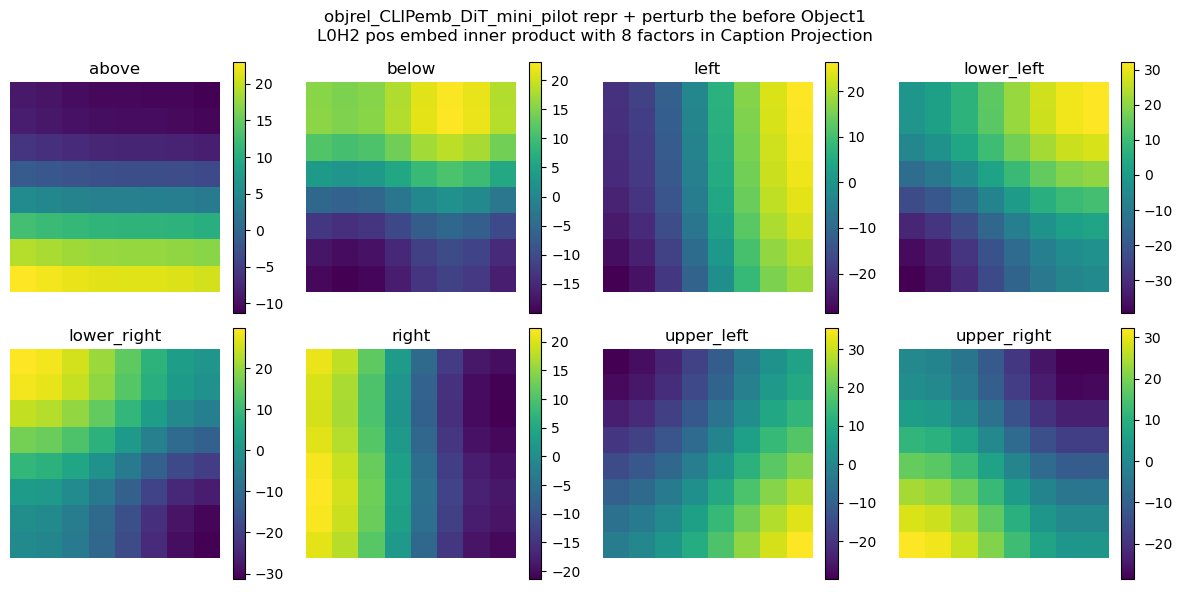

,cosine,projection,energy,template_norm,rel_name,dvec,dir_idx
0,-0.976844,-92.983304,95.1875,5.237229,above,"(0, -1)",0
1,-0.956924,-107.115629,111.9375,5.237229,below,"(0, 1)",1
2,-0.980316,-137.611846,140.3750,5.237229,left,"(-1, 0)",2
3,-0.983109,-150.661399,153.2500,5.237229,lower_left,"(-1, 1)",3
4,-0.983210,-129.292156,131.5000,5.237229,lower_right,"(1, 1)",4
5,-0.986123,-121.231439,122.9375,5.237229,right,"(1, 0)",5
6,-0.982977,-129.752937,132.0000,5.237229,upper_left,"(-1, -1)",6
7,-0.987067,-128.071950,129.7500,5.237229,upper_right,"(1, -1)",7


In [156]:
inner_prod_mat = compute_vis_pos_embed_inner_prod(pipeline, config, layer_idx=0, head_idx=2, feature_vecs=effect_vecs["spatial_relationship"] + the1_pert_vecs_mean.detach().cpu().numpy()[None, :], 
                                levels_names=levels_map["spatial_relationship"], 
                                model_run_name=run_name + " repr + perturb the before Object1", device="cuda", visualize=True);
align_df = eval_ramp_alignment_all(inner_prod_mat, levels_map["spatial_relationship"])
display(align_df)

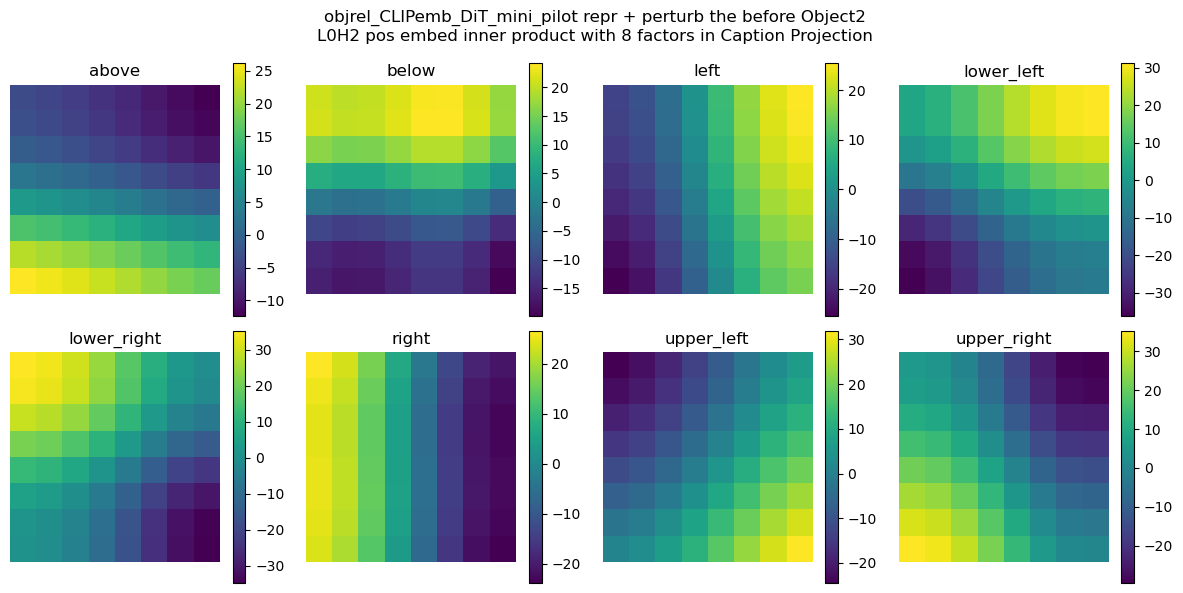

,cosine,projection,energy,template_norm,rel_name,dvec,dir_idx
0,-0.937539,-84.437111,90.0625,5.237229,above,"(0, -1)",0
1,-0.968658,-115.633585,119.3750,5.237229,below,"(0, 1)",1
2,-0.963575,-118.640228,123.1250,5.237229,left,"(-1, 0)",2
3,-0.960664,-143.258982,149.1250,5.237229,lower_left,"(-1, 1)",3
4,-0.983380,-148.736299,151.2500,5.237229,lower_right,"(1, 1)",4
5,-0.988188,-140.199241,141.8750,5.237229,right,"(1, 0)",5
6,-0.989276,-110.304292,111.5000,5.237229,upper_left,"(-1, -1)",6
7,-0.979827,-135.461031,138.2500,5.237229,upper_right,"(1, -1)",7


In [157]:
inner_prod_mat = compute_vis_pos_embed_inner_prod(pipeline, config, layer_idx=0, head_idx=2, feature_vecs=effect_vecs["spatial_relationship"] + the2_pert_vecs_mean.detach().cpu().numpy()[None, :], 
                                levels_names=levels_map["spatial_relationship"], 
                                model_run_name=run_name + " repr + perturb the before Object2", device="cuda", visualize=True);
align_df = eval_ramp_alignment_all(inner_prod_mat, levels_map["spatial_relationship"])
display(align_df)